# Homework 4
### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018


## Problem

The flux vs. time plot below shows UV flux measurements for an active M dwarf
star. These stars are known for their exponential bursts of energy, well described
by the profile:

$$\rm{flux(time)} = A\,exp(-\alpha \, t)$$ 

for $t>T$ (recall Week-5-Thu lecture).

Find how many bursts were observed for this star during the provided 2 hour 
stretch of data and estimate their amplitudes (A), decay constants ($\alpha$),
and the time of bursts.

**Hints:**
- You can relatively easily solve this problem by generalizing the code from [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)
- There are no more than 2 bursts in this dataset. I.e., you can fit a single-burst model, and then a double-burst model, and then compare which one fits better. Show the posteriors plots (like in [fig. 10.25](http://www.astroml.org/book_figures/chapter10/fig_matchedfilt_burst.html)) for both models.
- You can use flat priors for A and T and the background (non-bursting) flux level, and Jeffreys' prior, $p(\alpha) \propto \alpha^{-1}$, for $\alpha$
- You can do approximate model comparison based on the BIC 

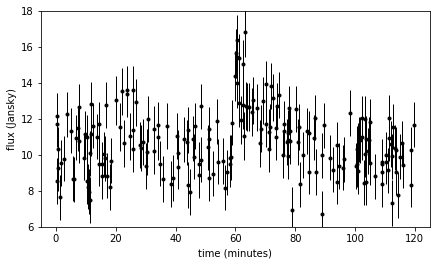

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# read data
data = np.loadtxt('data/HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
#ax.plot(t, y_obs,'.', lw=1, c='k')
ax.errorbar(t, y_obs, sigma_y, fmt='.', lw=1, c='k')
ax.set_xlim(-5, 125)
ax.set_ylim(6.0, 18.001)
ax.set_xlabel('time (minutes)')
ax.set_ylabel(r'flux (Jansky)')

plt.show()

## Solution

 [-----------------100%-----------------] 25000 of 25000 complete in 7.7 sec

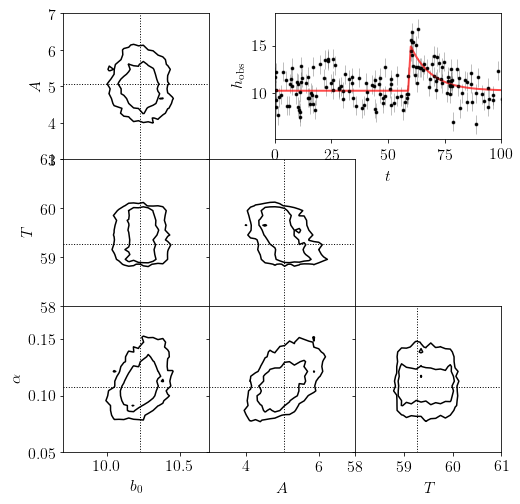

The required b0, A, Alpha, T values are:  10.229475289952564 5.061830062684821 0.107680413661 59.274602462641724  respectively


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.misc
scipy.derivative = scipy.misc.derivative
import pymc
from astroML.plotting.mcmc import plot_mcmc
from astroML.decorators import pickle_results
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=16, usetex=True)

# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)     #creates an array of size t.shape with random elements
    y.fill(b0)                #fills the array y with the value b0 for all elements
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

np.random.seed(0)

N = len(t) 
sigma=1.0
#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
limits = [(9.7, 10.7), (3, 7), (58, 61), (0.05, 0.18)]
obs = [b0, A, T, alpha]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=obs, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = t
y_fit = burst(t_fit, *fit_vals)


ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=0.5, c='k', alpha=0.5)
ax.plot(t_fit, y_fit, '-k', c='red', lw =  2, alpha=0.7)
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show() 

print("The required b0, A, Alpha, T values are: ", (*fit_vals), " respectively")


### Fitting the first peak

In [4]:
cond1=(t<=50)
t=t[cond1]
y_obs=y_obs[cond1]
sigma_y=sigma_y[cond1]

 [-----------------100%-----------------] 25000 of 25000 complete in 6.7 sec

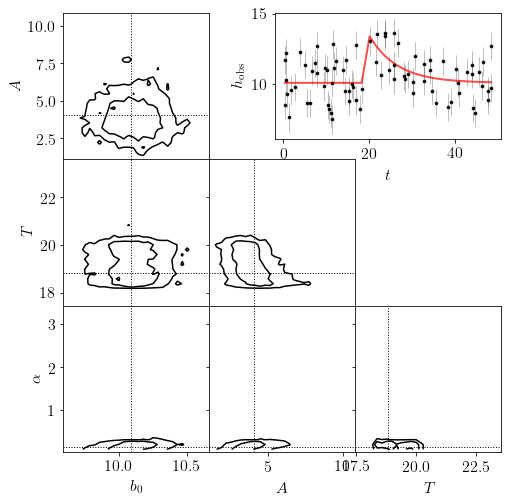

The required b0, A, Alpha, T values are:  10.086346149163461 4.0451287760035335 0.152180054882 18.8117206595685  respectively


In [5]:
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)     #creates an array of size t.shape with random elements
    y.fill(b0)                #fills the array y with the value b0 for all elements
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y

np.random.seed(0)

N = len(t) 
sigma=1.0
#----------------------------------------------------------------------
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 120, value=120 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)


#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

traces, fit_vals = compute_MCMC_results()

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']
#limits = [(9.7, 10.7), (3, 7), (58, 61), (0.05, 0.18)]
obs = [b0, A, T, alpha]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels,  true_values=obs, fig=fig,
          bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = t
y_fit = burst(t_fit, *fit_vals)


ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.errorbar(t, y_obs, sigma, fmt='.', lw=0.5, c='k', alpha=0.5)
ax.plot(t_fit, y_fit, '-k', c='red', lw =  2, alpha=0.7)

ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show() 

print("The required b0, A, Alpha, T values are: ", (*fit_vals), " respectively")


### Double Mixture

In [6]:
data = np.loadtxt('data/HW4dataFinal.txt', unpack=True)
t, y_obs, sigma_y = data

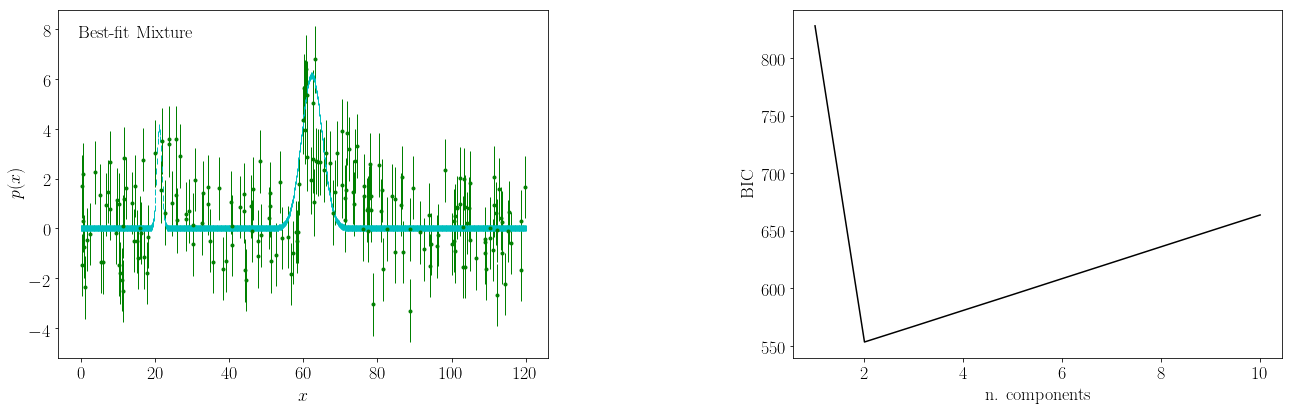

In [7]:
### Modeled after astroML book figure 4.2  
import warnings
warnings.filterwarnings('ignore')
from sklearn.mixture import GMM
setup_text_plots(fontsize=18, usetex=True)

def doGMM(Ndata, noiseStd=0.00000001):
    #------------------------------------------------------------
    # Set up the dataset.
    #  We'll use scikit-learn's Gaussian Mixture Model to sample
    #  data from a mixture of Gaussians.  The usual way of using
    #  this involves fitting the mixture to data: we'll see that
    #  below.  Here we'll set the internal means, covariances,
    #  and weights by-hand.
    np.random.seed(1)
    gmm = GMM(2, n_iter=1)
    gmm.means_ = np.array([[19.155652110392897+2.0], [59.9910090852369+2.0]])
    gmm.covars_ = np.array([[1], [3]]) ** 2
    gmm.weights_ = np.array([0.13,0.87])

    X = gmm.sample(Ndata)
    #------------------------------------------------------------
    # Learn (train) the best-fit GMM models
    # Here we'll use GMM in the standard way: the fit() method
    # uses an Expectation-Maximization approach to find the best
    # mixture of Gaussians for the data

    # fit models with 1-10 components
    N = np.arange(1, 11)
    models = [None for i in range(len(N))]
    
    for i in range(len(N)):
        models[i] = GMM(N[i]).fit(X)

    # compute the BIC
    BIC = [m.bic(X) for m in models]

    #------------------------------------------------------------
    # Plot the results
    #  We'll use two panels:
    #   1) data + best-fit mixture
    #   2) BIC vs number of components 

    fig = plt.figure(figsize=(20, 7))
    fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


    # plot 1: data + best-fit mixture
    ax = fig.add_subplot(121)
    M_best = models[np.argmin(BIC)]

    x = np.linspace(0, 120, 1000)
    logprob, responsibilities = M_best.score_samples(x.reshape((-1,1))) ## fix
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

   
    ax.errorbar(t, y_obs-10.0, sigma_y, fmt='.', lw=1, c='g')
    ax.plot(x, 50*pdf ,'|c')
    ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')


    # plot 2: BIC
    ax = fig.add_subplot(122)
    ax.plot(N, BIC, '-k')
    ax.set_xlabel('n. components')
    ax.set_ylabel('BIC')

    plt.show()
    
doGMM(100)    

The BIC value for double fit is lower. Hence it is the better fit.